In [1]:
import tensorflow as tf
print(tf.__version__)
import yaml
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from source.image_processing import *
import numpy as np

2.0.0-beta1


In [2]:
with open("./config/coco.yml", 'r') as stream:
    meta_parameters = yaml.safe_load(stream)

DISC_UPDATE = meta_parameters['disc_update']
IMG_SIZE = meta_parameters['dataset']['img_size']
BATCH_SIZE = 1 #meta_parameters['batchsize']
BUFFER_SIZE = 2048
EPOCHS = meta_parameters['epochs']
SUMMARY_EVERY_N_STEPS = meta_parameters['summary_every_n_steps']
SAVE_EVERY_N_STEPS = meta_parameters['save_every_n_steps']
PATCH_SIZE = meta_parameters['dataset']['img_size']

In [3]:
def random_noise(input_, target):
  bound = 1. / 128
  input_ += tf.random.uniform(shape=input_.shape, minval=-bound, maxval=bound)
  target += tf.random.uniform(shape=target.shape, minval=-bound, maxval=bound)
  return input_, target

def process_tfds(features, HEIGHT, WIDTH):
  image = features["image"]
  image = tf.reshape(image, tf.shape(image))
  image = tf.image.resize(image,
        size=(160, 160), method=tf.image.ResizeMethod.BILINEAR,
        preserve_aspect_ratio=True)
  image = tf.image.resize_with_crop_or_pad(image,target_height=HEIGHT,target_width=WIDTH)
  return tf.cast(image, tf.float32)

def random_crop(image, HEIGHT, WIDTH, CHANNELS=3):
  image = tf.image.random_crop(image, size=[HEIGHT, WIDTH, CHANNELS])
  return image

def random_flip(image):
  return tf.image.random_flip_left_right(image)

def random_resize(image):
  # Random resize an image
  # For image of original size of 384x384
  # The output can have a maximum height and/or width of [461]
  # and minimum height and/or width of 307
  H, W = image.shape[:2]
  scale = tf.random.uniform([], minval=1., maxval=1.2, dtype=tf.float32, seed=None, name=None)
  shape = tf.stack((scale * W, scale * H), axis=0)
  shape = tf.cast(shape, tf.int32)
  image = tf.image.resize(image, size=shape)
  return image

In [4]:
# test_dataset = tf.data.Dataset.list_files("/home/thalles/Documents/valid_64x64/*.png")
test_dataset = tfds.load(name="cats_vs_dogs", split=tfds.Split.TRAIN)
test_dataset = test_dataset.map(lambda x: process_tfds(x, IMG_SIZE, IMG_SIZE))
test_dataset = test_dataset.map(rgb_to_lab)
test_dataset = test_dataset.map(preprocess_lab)
test_dataset = test_dataset.repeat(1)
test_dataset = test_dataset.batch(1)

Range L batch -1.0 0.7473029
Range AB batch -0.13860086 0.29558134


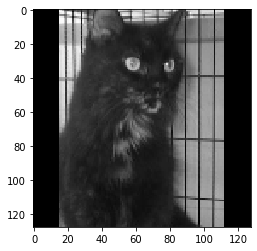

In [5]:
for L_batch, AB_batch in test_dataset.take(20):
    print("Range L batch",np.min(L_batch), np.max(L_batch))
    print("Range AB batch", np.min(AB_batch), np.max(AB_batch))
    plt.imshow(tf.squeeze(L_batch[0]), cmap="gray")
    plt.show()
    break

In [6]:
train_dataset = tfds.load(name="cats_vs_dogs", split=tfds.Split.ALL)
train_dataset = train_dataset.map(lambda x: process_tfds(x, IMG_SIZE, IMG_SIZE))
train_dataset = train_dataset.map(random_resize)
train_dataset = train_dataset.map(lambda x: random_crop(x, PATCH_SIZE, PATCH_SIZE))
train_dataset = train_dataset.map(random_flip)
train_dataset = train_dataset.map(rgb_to_lab)
train_dataset = train_dataset.map(preprocess_lab)
train_dataset = train_dataset.map(random_noise)
train_dataset = train_dataset.repeat(1)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

(1, 128, 128, 1)
Range L batch -1.007812 0.96577096
Range AB batch -0.22028936 0.2977704


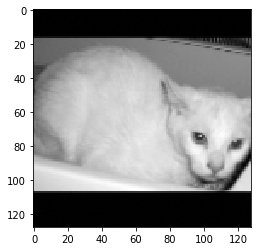

(1, 128, 128, 1)
Range L batch -1.007746 1.0005298
Range AB batch -0.11728634 0.4012311


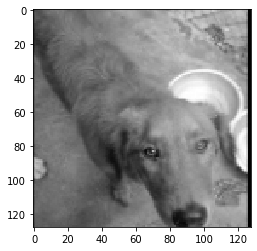

(1, 128, 128, 1)
Range L batch -0.89238316 0.9146909
Range AB batch -0.18855684 0.37813586


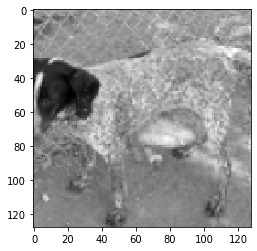

(1, 128, 128, 1)
Range L batch -0.8482194 0.8913925
Range AB batch -0.3781847 0.2087067


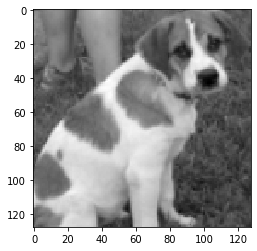

(1, 128, 128, 1)
Range L batch -1.007812 0.9975491
Range AB batch -0.5620496 0.6459061


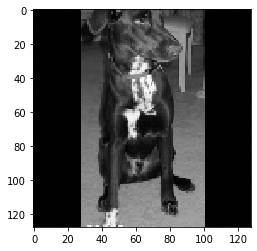

(1, 128, 128, 1)
Range L batch -1.0077697 0.85478425
Range AB batch -0.2126958 0.28452665


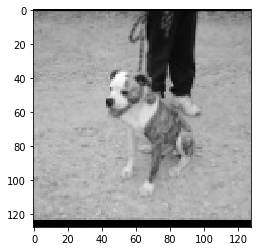

(1, 128, 128, 1)
Range L batch -1.0078092 0.9389657
Range AB batch -0.3446295 0.43710288


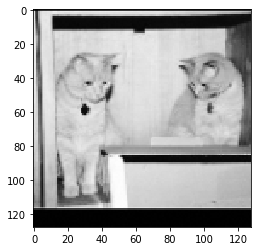

(1, 128, 128, 1)
Range L batch -1.0078111 0.25355348
Range AB batch -0.11376968 0.21582285


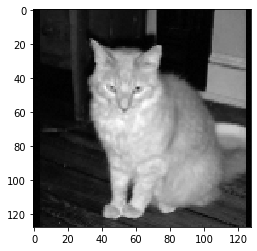

(1, 128, 128, 1)
Range L batch -0.81042075 1.0025576
Range AB batch -0.19446245 0.54421604


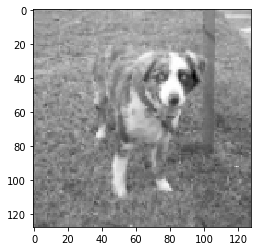

(1, 128, 128, 1)
Range L batch -0.8539405 0.92451787
Range AB batch -0.10188458 0.23533039


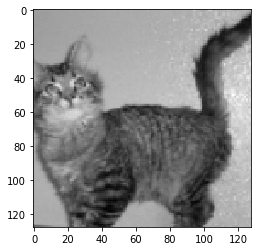

In [7]:
for L_batch, AB_batch in train_dataset.take(10):
    print(L_batch.shape)
    print("Range L batch",np.min(L_batch), np.max(L_batch))
    print("Range AB batch", np.min(AB_batch), np.max(AB_batch))
    plt.imshow(tf.squeeze(L_batch[0]), cmap="gray")
    plt.show()